In [1]:
import sys
import logging
import pickle

import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
from figure8_env import MyEnv as figure8_env
import deer.experiment.base_controllers as bc

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
figure8_give_rewards = True
nn_yaml = 'network_noconv.yaml'
high_dim_obs = False
internal_dim = 10
fname = '2d_obs'
set_network = None #['expanded_tcm', 15, True]

In [3]:
class Defaults:
    # ----------------------
    # Setup Parameters (copied for convenience)
    # ----------------------
    figure8_give_rewards = figure8_give_rewards
    nn_yaml = nn_yaml
    high_dim_obs = high_dim_obs
    internal_dim = internal_dim
    fname = fname
    
    # ----------------------
    # Experiment Parameters
    # ----------------------
    steps_per_epoch = 500 #2500
    epochs = 50
    steps_per_test = 1000
    period_btw_summary_perfs = 1

    # ----------------------
    # Temporal Processing Parameters
    # ----------------------
    nstep = 15
    nstep_decay = 0.8
    expand_tcm = True
    encoder_type = 'regular'
    
    # ----------------------
    # Environment Parameters
    # ----------------------
    frame_skip = 2
    show_rewards = False

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    learning_rate = 1*1E-4
    learning_rate_decay = 1.0
    discount = 0.9
    epsilon_start = 1.0
    epsilon_min = 1.0
    epsilon_decay = 1000
    update_frequency = 1
    replay_memory_size = 100000 #50000
    batch_size = 64
    freeze_interval = 1000
    deterministic = False
    
    # ----------------------
    # Learning algo parameters
    # ----------------------
    # T, entropy_neighbor, entropy_random, volume, gamma, R, Q, variational
    #loss_weights = [5E-3, 1E-3, 5E-3, 5E-3, 5E-3, 5E-3, 1.]
    loss_weights = [0, 0, 0, 0, 0, 0, 1., 0.]
    #loss_weights = [0., 0., 0., 0., 0., 0., 1., 2E-4]
    #loss_weights = [5E-3, 1E-3, 5E-3, 5E-3, 5E-3, 5E-3, 0., 0.]

In [4]:
parameters = Defaults()
with open(f'params/{fname}.p', 'wb') as f:
    pickle.dump(parameters, f)

In [5]:
if parameters.deterministic:
    rng = np.random.RandomState(123456)
else:
    rng = np.random.RandomState()

# --- Instantiate environment ---
env = figure8_env(
    give_rewards=figure8_give_rewards,
    intern_dim=internal_dim,
    high_dim_obs=high_dim_obs,
    show_rewards=parameters.show_rewards
    )

# --- Instantiate learning_algo ---
learning_algo = CRAR(
    env,
    parameters.freeze_interval,
    parameters.batch_size,
    rng,
    high_int_dim=False,
    internal_dim=internal_dim, lr=parameters.learning_rate,
    nn_yaml=nn_yaml, double_Q=True,
    loss_weights=parameters.loss_weights,
    nstep=parameters.nstep, nstep_decay=parameters.nstep_decay,
    encoder_type=parameters.encoder_type,
    expand_tcm=parameters.expand_tcm
    )

if figure8_give_rewards:
    train_policy = EpsilonGreedyPolicy(
        learning_algo, env.nActions(), rng, 0.2,
        consider_valid_transitions=False
        )
    test_policy = EpsilonGreedyPolicy(
        learning_algo, env.nActions(), rng, 0.
        )
else:
    train_policy = FixedFigure8Policy.FixedFigure8Policy(
        learning_algo, env.nActions(), rng, epsilon=0.2,
        height=env.HEIGHT, width=env.WIDTH
        )
    test_policy = FixedFigure8Policy.FixedFigure8Policy(
        learning_algo, env.nActions(), rng,
        height=env.HEIGHT, width=env.WIDTH
        )

# --- Instantiate agent ---
agent = NeuralAgent(
    env, learning_algo,
    parameters.replay_memory_size,
    1, parameters.batch_size, rng,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )

agent.run(10, 500)
print("end gathering data")

# --- Bind controllers to the agent ---
# Before every training epoch (periodicity=1), we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController(
    evaluate_on='epoch', 
    periodicity=1))

# Learning rate may follow a scheduler
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters.learning_rate, 
    learning_rate_decay=parameters.learning_rate_decay,
    periodicity=1))

# During training epochs, we want to train the agent after every [parameters.update_frequency] action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode, hence the two last arguments.
agent.attach(bc.TrainerController(
    evaluate_on='action', 
    periodicity=parameters.update_frequency, 
    show_episode_avg_V_value=True, 
    show_avg_Bellman_residual=True))

# We wish to discover, among all versions of our neural network (i.e., after every training epoch), which one 
# has the highest validation score.
# To achieve this goal, one can use the FindBestController along with an InterleavedTestEpochControllers. It is 
# important that the validationID is the same than the id argument of the InterleavedTestEpochController.
# The FindBestController will dump on disk the validation scores for each and every network, as well as the 
# structure of the neural network having the best validation score. These dumps can then used to plot the evolution 
# of the validation and test scores (see below) or simply recover the resulting neural network for your 
# application.
agent.attach(bc.FindBestController(
    validationID=figure8_env.VALIDATION_MODE,
    testID=None,
    unique_fname=fname, savefrequency=5))

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "validation epoch" between each training epoch. For each validation epoch, we want also to display the sum of all 
# rewards obtained, hence the showScore=True. Finally, we want to call the summarizePerformance method of ALE_env 
# every [parameters.period_btw_summary_perfs] *validation* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=figure8_env.VALIDATION_MODE, 
    epoch_length=parameters.steps_per_test,
    periodicity=1,
    show_score=True,
    summarize_every=1,
    unique_fname=fname))

end gathering data


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2169, -0.2138, -0.2002, -0.2997,  0.0520,  0.0861, -0.3867,  0.2148,
        -0.2754, -0.2141], device='cuda:0') tensor([-0.2596, -0.2384, -0.1999, -0.3840,  0.2675,  0.1650, -0.6807,  0.3535,
        -0.3365,  0.0520], device='cuda:0') tensor([-0.2113, -0.1796, -0.1997, -0.2625,  0.0304,  0.1231, -0.3558,  0.2391,
        -0.2736, -0.2178], device='cuda:0')
R[0]
tensor([-0.1209], device='cuda:0', grad_fn=<SelectBackward0>)
LOSSES
T = 0.02563558818772435; R = 0.027333837892860174;                 Gamma = 1.0421735678911208; Q = 0.0016872097974155622;
Entropy Neighbor = 0.797719453215599;                 Entropy Random = 0.4930156142711639;                 Volume = 0.0008060463853180409; VAE = 0.0
Average (on the epoch) training loss: 0.0016872097974155622
Episode average V value: 0.00800483629712835
epoch 1:
Learning rate: 0.0001
Discount factor: 0.

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
== Mean score per episode is 0.0 over 1 episodes ==


/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:268: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  torch.as_tensor([action_encoding]).to(device)


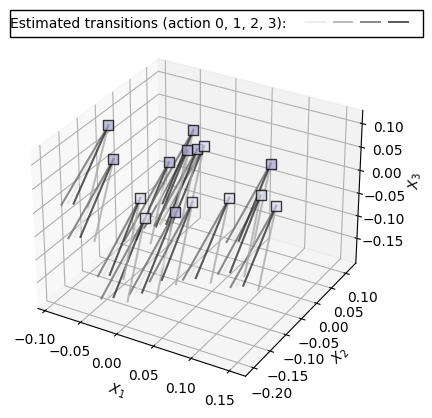

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2513, -0.2678, -0.4053,  0.0439,  0.0752, -0.1957, -0.5399,  0.4293,
        -0.6535, -0.6876], device='cuda:0') tensor([-0.2919, -0.2903, -0.4105, -0.0293,  0.2823, -0.1174, -0.8407,  0.5718,
        -0.7210, -0.4276], device='cuda:0') tensor([-0.2513, -0.2678, -0.4053,  0.0439,  0.0752, -0.1957, -0.5399,  0.4293,
        -0.6535, -0.6876], device='cuda:0')
R[0]
tensor([-0.1593], device='cuda:0', grad_fn=<SelectBackward0>)
LOSSES
T = 0.027607643522322176; R = 0.027386619839817286;                 Gamma = 1.0211944882869721; Q = 0.0006013308056499227;
Entropy Neighbor = 0.783531401515007;                 Entropy Random = 0.45697843194007876;                 Volume = 0.0030494008138775824; VAE = 0.0
Average (on the epoch) training loss: 0.0006013308056499227
Episode average V value: 0.013059113918986905
epoch 2:
Learning rate: 0.0001
Discount factor:

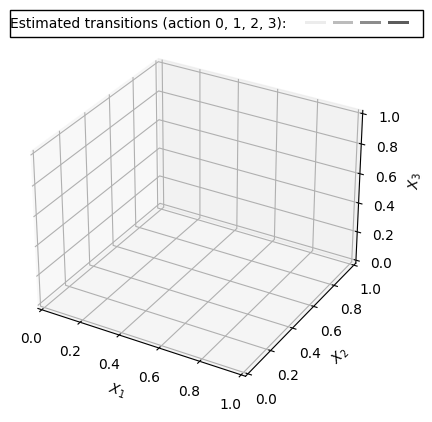

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:366: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2679,  0.0435, -0.3808, -0.1185,  0.0801, -0.3899, -0.3416,  0.4959,
        -0.6609, -0.5744], device='cuda:0') tensor([-0.3077,  0.0185, -0.3764, -0.2005,  0.2934, -0.3030, -0.6303,  0.6327,
        -0.7183, -0.3090], device='cuda:0') tensor([-0.2539,  0.0486, -0.3654, -0.1205,  0.0794, -0.3950, -0.3300,  0.5036,
        -0.6524, -0.5726], device='cuda:0')
R[0]
tensor([-0.1618], device='cuda:0', grad_fn=<SelectBackward0>)
LOSSES
T = 0.026802521839737893; R = 0.02854608101397753;                 Gamma = 1.0189608372449874; Q = 0.000684117682838405;
Entropy Neighbor = 0.7921134091615677;                 Entropy Random = 0.518944477558136;                 Volume = 0.0017873525880277156; VAE = 0.0
Average (on the epoch) training loss: 0.000684117682838405
Episode average V value: 0.017808168494741698
epoch 3:
Learning rate: 0.0001
Discount factor: 0.9

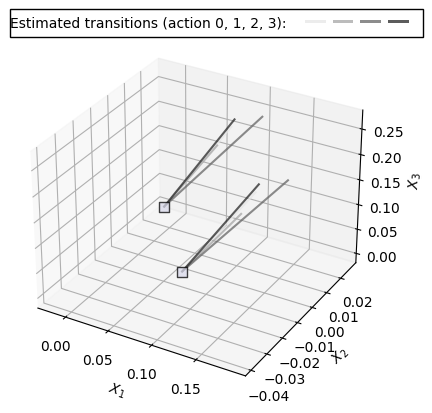

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.3687, -0.0425, -0.4367, -0.1085,  0.0063, -0.3556, -0.4984,  0.5126,
        -0.7076, -0.6612], device='cuda:0') tensor([-0.4082, -0.0663, -0.4378, -0.1855,  0.2169, -0.2695, -0.7907,  0.6524,
        -0.7686, -0.3977], device='cuda:0') tensor([-0.3732, -0.0564, -0.4416, -0.1046,  0.0159, -0.3673, -0.5097,  0.5055,
        -0.7137, -0.6685], device='cuda:0')
R[0]
tensor([-0.1681], device='cuda:0', grad_fn=<SelectBackward0>)
LOSSES
T = 0.02663907715305686; R = 0.03054576304927468;                 Gamma = 1.0259029026031494; Q = 0.0005833305152536923;
Entropy Neighbor = 0.8040225938558578;                 Entropy Random = 0.5465108954310417;                 Volume = 0.001223907746374607; VAE = 0.0
Average (on the epoch) training loss: 0.0005833305152536923
Episode average V value: 0.019170963167212902
epoch 4:
Learning rate: 0.0001
Discount factor: 0.

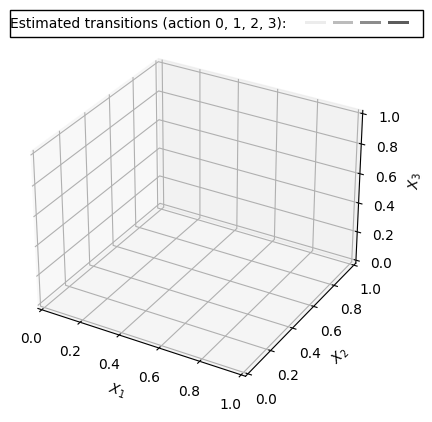

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:366: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.4835, -0.0815, -0.5425, -0.0819, -0.0081, -0.3647, -0.5515,  0.4982,
        -0.7342, -0.7269], device='cuda:0') tensor([-0.5221, -0.1057, -0.5468, -0.1575,  0.2020, -0.2778, -0.8456,  0.6388,
        -0.7958, -0.4639], device='cuda:0') tensor([-0.4701, -0.0865, -0.5221, -0.0910,  0.0017, -0.3707, -0.5577,  0.4959,
        -0.7297, -0.7192], device='cuda:0')
R[0]
tensor([-0.1759], device='cuda:0', grad_fn=<SelectBackward0>)
LOSSES
T = 0.02671973920613527; R = 0.03130367412045598;                 Gamma = 1.0270743312835693; Q = 0.0006954873974063957;
Entropy Neighbor = 0.8048865538835526;                 Entropy Random = 0.5401562764644623;                 Volume = 0.0010760091617703438; VAE = 0.0
Average (on the epoch) training loss: 0.0006954873974063957
Episode average V value: 0.010200802051462234
epoch 5:
Learning rate: 0.0001
Discount factor: 0

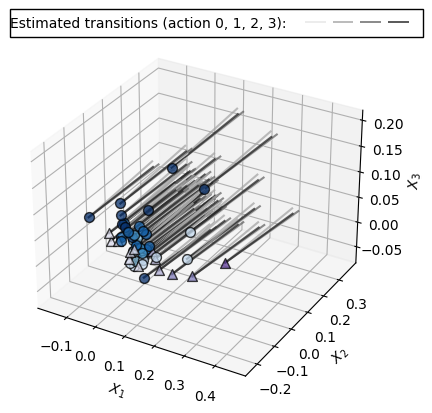

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.4836, -0.0062, -0.5303, -0.1492, -0.0916, -0.3217, -0.4960,  0.5360,
        -0.6515, -0.6753], device='cuda:0') tensor([-0.5233, -0.0293, -0.5315, -0.2274,  0.1203, -0.2358, -0.7876,  0.6750,
        -0.7110, -0.4107], device='cuda:0') tensor([-0.4836, -0.0062, -0.5303, -0.1492, -0.0916, -0.3217, -0.4960,  0.5360,
        -0.6515, -0.6753], device='cuda:0')
R[0]
tensor([-0.1747], device='cuda:0', grad_fn=<SelectBackward0>)
LOSSES
T = 0.02678961172699928; R = 0.03147046303376556;                 Gamma = 1.0201668157577515; Q = 0.000693873150710715;
Entropy Neighbor = 0.8033433821201325;                 Entropy Random = 0.5515422698259353;                 Volume = 0.0009956958070397378; VAE = 0.0
Average (on the epoch) training loss: 0.000693873150710715
Episode average V value: 0.024439939504489302
epoch 6:
Learning rate: 0.0001
Discount factor: 0.9

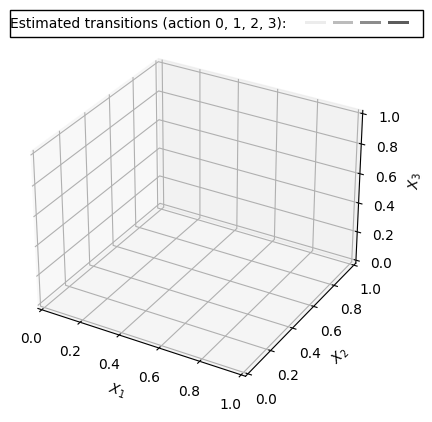

/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:366: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/share/ctn/users/cf2794/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.5042,  0.0656, -0.5601, -0.1771, -0.1452, -0.2985, -0.4489,  0.5576,
        -0.6188, -0.6568], device='cuda:0') tensor([-0.5442,  0.0428, -0.5592, -0.2577,  0.0684, -0.2123, -0.7383,  0.6954,
        -0.6760, -0.3908], device='cuda:0') tensor([-0.5042,  0.0656, -0.5601, -0.1771, -0.1452, -0.2985, -0.4489,  0.5576,
        -0.6188, -0.6568], device='cuda:0')
R[0]
tensor([-0.1761], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
try:
    os.mkdir("params")
except Exception:
    pass
dump(vars(parameters), "params/" + fname + ".jldump")
#agent.gathering_data=False
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters.epochs, parameters.steps_per_epoch)

# --- Show results ---
basename = "scores/" + fname
scores = load(basename + "_scores.jldump")
print(scores)

In [ ]:
agent._learning_algo.device

## Visualize performance

In [ ]:
agent.setNetwork(fname, nEpoch=7)

In [ ]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

### Frame by frame

In [ ]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
    plt.figure()
    plt.imshow(np.flip(_obs.squeeze()))
    plt.show()
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward, _ = agent._step()
    print(action)
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()
    if is_terminal: break

### As animation

In [ ]:
%matplotlib notebook

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
obs = env.observe()
_obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
_obs = np.flip(_obs.squeeze())
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.zeros(_obs.shape))

def init():
    plt.cla()
    im = ax.imshow(_obs)
    return [im]

def animate(i, *args, **kwargs):
    plt.cla()
    obs = env.observe()
    _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
    _obs = np.flip(_obs.squeeze())
    im = ax.imshow(_obs)
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
        V, action, reward, _ = agent._step()
        agent._Vs_on_last_episode.append(V)
    return [im]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
     frames=100, blit=False, repeat=True)
ani.save(f'figs/{fname}/behavior.gif', writer="ffmpeg", fps = 15)
fig.show()